# Programming Exercise 5: Regularized Linear Regression and Bias v.s.Variance

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import random #select random samples from X
import scipy.io #Used to load the OCTAVE *.mat files
from PIL import Image #display image from matrix '''sudo pip install pillow'''
import matplotlib.cm as cm #Used to display images in a specific colormap
import random #To pick random images to display
from scipy.special import expit as sigmod #Vectorized sigmoid function

import warnings
warnings.filterwarnings('ignore')

##  1 Regularized Linear Regression
In the first half of the exercise, you will implement regularized linear regression to predict the amount of water flowing out of a dam using the change of water level in a reservoir. In the next half, you will go through some diagnostics of debugging learning algorithms and examine the effects of bias v.s. variance.

In [2]:
#extract data from file
mat = scipy.io.loadmat('ex5/ex5data1.mat')
X, y = mat['X'], mat['y']
Xval, yval = mat['Xval'], mat['yval']
Xtest, ytest = mat['Xtest'], mat['ytest']
#insert a column of 1
X =     np.insert(X    ,0,1,axis=1)
Xval =  np.insert(Xval ,0,1,axis=1)
Xtest = np.insert(Xtest,0,1,axis=1)

print('X shape = %s' %(X.shape,))
print('y shape = %s' %(y.shape,))
print('Xvals shape = %s' %(Xval.shape,))
print('yvals shape = %s' %(yval.shape,))
print('Xtest shape = %s' %(Xtest.shape,))
print('ytest shape = %s' %(ytest.shape,))

X shape = (12, 2)
y shape = (12, 1)
Xvals shape = (21, 2)
yvals shape = (21, 1)
Xtest shape = (21, 2)
ytest shape = (21, 1)


### 1.1 Visualizing the dataset

Text(0, 0.5, 'Water flowing out of the dam (y)')

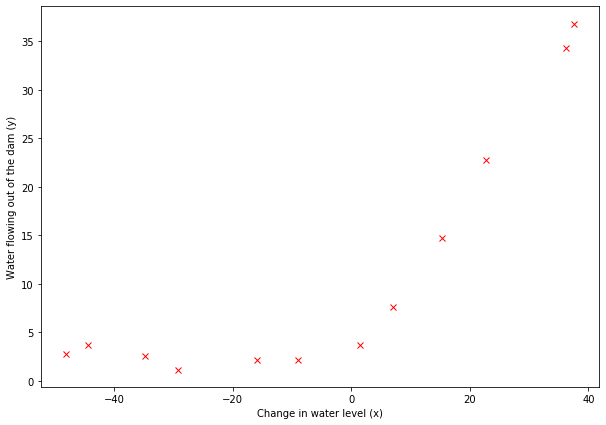

In [3]:
#plot the data
plt.figure(figsize = (10,7))
plt.plot(X[:,1],y,'rx')
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')

### 1.2 Regularized linear regression cost function

In [4]:
#hypothesis function
def h(theta,X):
    return np.dot(X,theta)

#regularized cost function
def J(theta,X,y,lamda=0.): #Cost function
    m = X.shape[0]
    hx = h(theta,X).reshape((m,1))
    costTerm = float((1./(2*m)) * np.dot((hx-y).T,(hx-y)))
    regTerm = (float(lamda)/(2*m)) * float(theta[1:].T.dot(theta[1:]))
    return costTerm + regTerm

In [5]:
#initialize theta
theta = np.array([[1.],[1.]])
print('initial cost = %lf' %(J(theta, X, y,1)))

initial cost = 303.993192


### 1.3 Regularized linear regression gradient

In [6]:
#regularized LR gradient
def computeGradient(theta, X, y, lamda = 0):
    m = X.shape[0]
    theta = theta.reshape((theta.shape[0],1))
    costTerm =  1./float(m)*np.dot(X.T,h(theta,X)-y) 
    regTerm = lamda/float(m)*theta
    regTerm[0] = 0
    regTerm.reshape((costTerm.shape[0],1))
    return costTerm + regTerm

#regularized LR gradient descent
def gradientDescent(theta, X, y,alpha, iterations, lamda = 0):
    m = X.shape[0]
    thetaHistory = [theta] #for plotting theta-iter
    costHistory = [J(theta,X,y)] #for plotting J-iter
    #start iteration
    for iter in range(1,iterations):
        theta = theta - alpha * computeGradient(theta, X, y, lamda)
        thetaHistory.append(theta)
        costHistory.append(J(theta,X,y))
    return theta, thetaHistory, costHistory

In [7]:
theta = np.array([[1.],[1.]])
print('initial gradient = \n%s ' %computeGradient(theta,X,y,1))

initial gradient = 
[[-15.30301567]
 [598.25074417]] 


### 1.4 Fitting linear regression

In [8]:
from scipy import optimize

def computeGradientFlatten(theta, X, y, lamda = 0):
    return computeGradient(theta, X, y,lamda).flatten()
    
def optimizeTheta(theta, X, y, lamda=0.,print_output=True):
    fit_theta = optimize.fmin_cg(J,x0=theta,\
                                       fprime=computeGradientFlatten,\
                                       args=(X,y,lamda),\
                                       disp=print_output,\
                                       epsilon=1.49e-12,\
                                       maxiter=1000)
    fit_theta = fit_theta.reshape((theta.shape[0],1))
    return fit_theta

In [9]:
theta_init = np.array([[1.],[1.]])
fit_theta = optimizeTheta(theta_init, X, y,0.)

Optimization terminated successfully.
         Current function value: 22.373906
         Iterations: 18
         Function evaluations: 28
         Gradient evaluations: 28


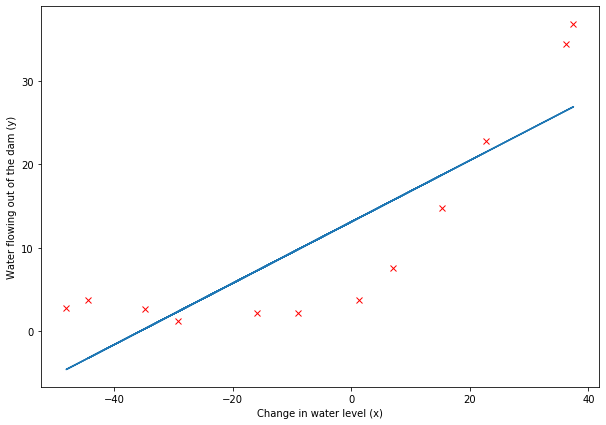

In [10]:
#plot the data
plt.figure(figsize = (10,7))
plt.plot(X[:,1],y,'rx')
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')
#plot the fitting line
plt.plot(X[:,1],h(fit_theta,X).flatten())

## 2 Bias-variance

### 2.1 Learning curves

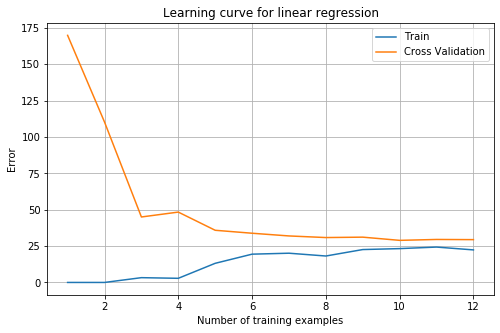

In [11]:
init_theta = np.array([[1.],[1.]])
set_size, error_train, error_cv = [], [], []
for x in range(1,13):
    train_subset = X[:x,:]
    y_subset = y[:x]
    set_size.append(len(y_subset))
    fit_theta = optimizeTheta(init_theta,train_subset,y_subset,lamda=0.,print_output=False)
    error_train.append(J(fit_theta,train_subset,y_subset,0.))
    error_cv.append(J(fit_theta,Xval,yval,0.))

plt.figure(figsize=(8,5))
plt.plot(set_size,error_train,label='Train')
plt.plot(set_size,error_cv,label='Cross Validation')
plt.legend()
plt.title('Learning curve for linear regression')
plt.xlabel('Number of training examples')
plt.ylabel('Error')
plt.grid(True)

## 3 Polynomial regression

In [12]:
def genPolyFeatures(myX,degree):
    assert degree>2
    #column: x^0 x^1 -----> add x^3 ,x^4, x^5, ..., x^p+1
    newX = myX.copy()
    for i in range(degree-2):
        dim = i+2
        newX = np.insert(newX,newX.shape[1],np.power(newX[:,1],dim),axis=1)
    return newX


def featureNormalize(myX):
    """
    Takes as input the X array (with bias "1" first column), does
    feature normalizing on the columns (subtract mean, divide by standard deviation).
    Returns the feature-normalized X, and feature means and stds in a list
    Note this is different than my implementation in assignment 1...
    I didn't realize you should subtract the means, THEN compute std of the
    mean-subtracted columns.
    Doesn't make a huge difference, I've found
    """
    Xnorm = myX.copy()
    stored_feature_means = np.mean(Xnorm,axis=0) #column-by-column
    Xnorm[:,1:] = Xnorm[:,1:] - stored_feature_means[1:]
    stored_feature_stds = np.std(Xnorm,axis=0,ddof=1)
    Xnorm[:,1:] = Xnorm[:,1:] / stored_feature_stds[1:]
    return Xnorm, stored_feature_means, stored_feature_stds

### 3.1 Learning Polynomial Regression

In [13]:
#feature mapping
degree = 5
mappedX = genPolyFeatures(X,degree)
#refit theta with mapped X
mappedX_norm, stored_means, stored_stds = featureNormalize(mappedX)
#Find fit parameters starting with 1's as the initial guess
theta_init = np.ones((mappedX_norm.shape[1],1))
fit_theta = optimizeTheta(theta_init,mappedX_norm,y,0.)

Optimization terminated successfully.
         Current function value: 0.303812
         Iterations: 49
         Function evaluations: 84
         Gradient evaluations: 84


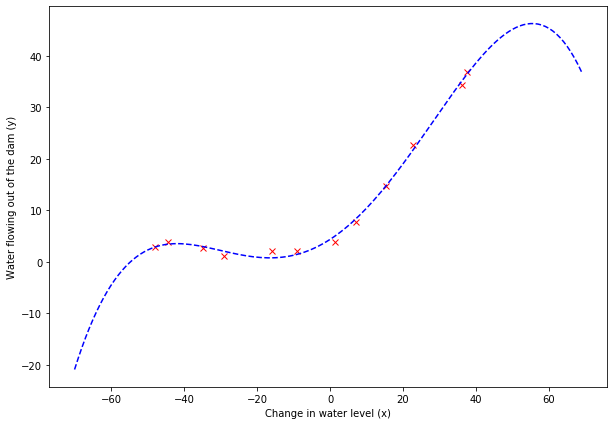

In [14]:
def plotFit(fit_theta, means, stds):
    #plot scatter data
    plt.figure(figsize = (10,7))
    plt.plot(X[:,1],y,'rx')
    plt.xlabel('Change in water level (x)')
    plt.ylabel('Water flowing out of the dam (y)')
    #plot fit
    xvals = np.insert(np.ones((140,1)),1,np.arange(-70,70,1),axis=1)
    mappedxvals = genPolyFeatures(xvals, degree)
    mappedxvals[:,1:] = mappedxvals[:,1:] - means[1:]
    mappedxvals[:,1:] = mappedxvals[:,1:] / stds[1:]
    plt.plot(xvals[:,1], h(fit_theta,mappedxvals).flatten(), 'b--')
    
plotFit(fit_theta,stored_means,stored_stds)

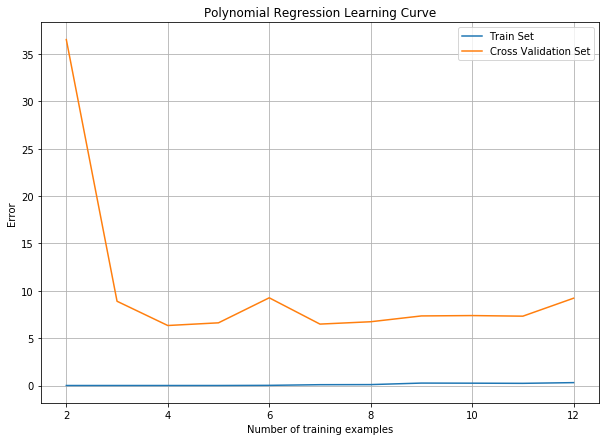

In [37]:
#require X, y, degree, 
def plotPolyLearningCurve(lamda):
    idx, err_train, err_cv = [], [], []
    #mappedXval, dummy1, dummy2 =  featureNormalize(genPolyFeatures(Xval,degree))
    
    for trainExamplesNo in range(1,13):
        #random select X subset examples
        #train_subset = X[random.sample(range(X.shape[0]),trainExamplesNo),:]
        train_subset = X[:trainExamplesNo,:]
        #mapped X subset 
        train_subset =  genPolyFeatures(train_subset,degree)
        #normalized X subset, keep means and stds for cross validdation use
        train_subset, means, stds = featureNormalize(train_subset)
        y_subset = y[:trainExamplesNo]
        theta_init = np.ones((train_subset.shape[1],1))
        theta_fit = optimizeTheta(theta_init, train_subset, y_subset, lamda, print_output=False)
        err_train.append(J(theta_fit, train_subset, y_subset,lamda))
        
        mappedXval = genPolyFeatures(Xval,degree)
        mappedXval[:,1:] = mappedXval[:,1:] - means[1:]
        mappedXval[:,1:] = mappedXval[:,1:] / stds[1:]

        err_cv.append(J(theta_fit, mappedXval, yval, lamda))
        idx.append(trainExamplesNo)

    plt.figure(figsize=(10,7))
    plt.plot(idx,err_train,label='Train Set')
    plt.plot(idx,err_cv,label='Cross Validation Set')
    plt.legend()
    plt.title('Polynomial Regression Learning Curve')
    plt.xlabel('Number of training examples')
    plt.ylabel('Error')
    plt.grid(True)
    
plotPolyLearningCurve(0.)

### 3.2 Optional (ungraded) exercise: Adjusting the regularization parameter

Optimization terminated successfully.
         Current function value: 7.644516
         Iterations: 25
         Function evaluations: 40
         Gradient evaluations: 40


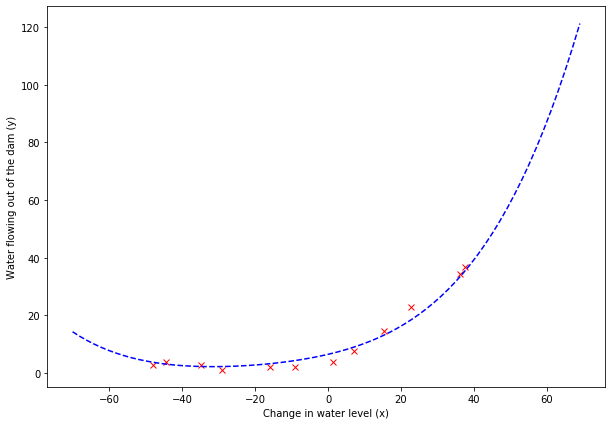

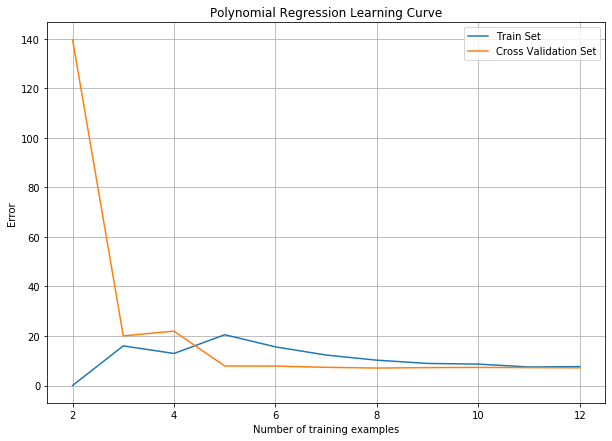

In [38]:
#Try lamda = 1
fit_theta = optimizeTheta(theta_init,mappedX_norm,y,1.)
plotFit(fit_theta, stored_means, stored_stds)
plotPolyLearningCurve(1.)

Optimization terminated successfully.
         Current function value: 36.466528
         Iterations: 10
         Function evaluations: 17
         Gradient evaluations: 17


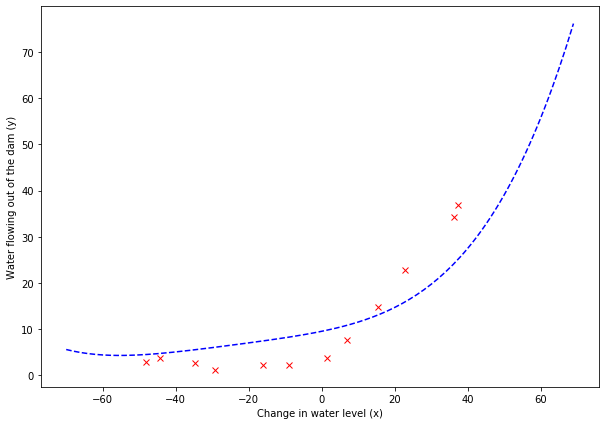

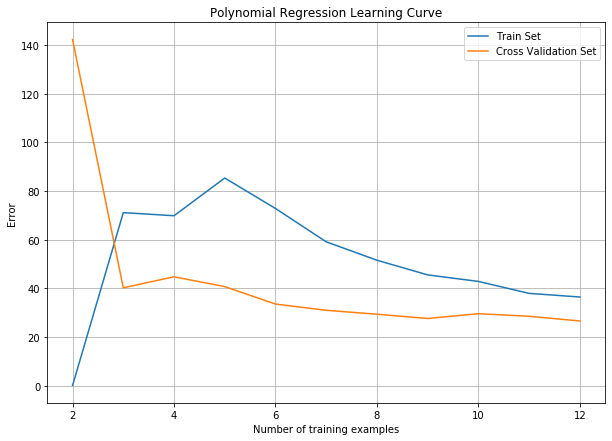

In [39]:
#Try lamda = 10
fit_theta = optimizeTheta(theta_init,mappedX_norm,y,10.)
plotFit(fit_theta, stored_means, stored_stds)
plotPolyLearningCurve(10.)

### 3.3 Selecting λ using a cross validation set

In [40]:
lamdas = np.arange(0,5,0.1)
err_train, err_cv = [], []
for lamda in lamdas:
    mappedX = genPolyFeatures(X,degree)
    mappedX_norm, dummy1, dummy2 = featureNormalize(mappedX)
    mappedXval = genPolyFeatures(Xval,degree)
    mappedXval_norm, dummy1, dummy2 = featureNormalize(mappedXval)
    init_theta = np.ones((mappedX_norm.shape[1],1))
    fit_theta = optimizeTheta(init_theta,mappedX_norm,y,lamda,False)
    err_train.append(J(fit_theta,mappedX_norm,y,lamda))
    err_cv.append(J(fit_theta,mappedXval_norm,yval,lamda))

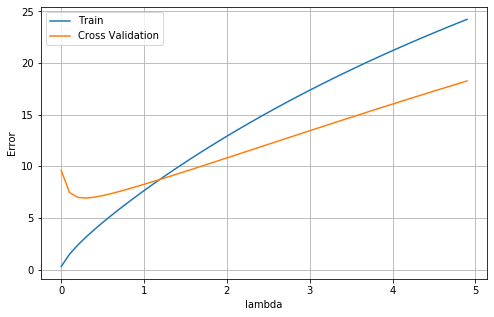

In [41]:
plt.figure(figsize=(8,5))
plt.plot(lamdas,err_train,label='Train')
plt.plot(lamdas,err_cv,label='Cross Validation')
plt.legend()
plt.xlabel('lambda')
plt.ylabel('Error')
plt.grid(True)

### 3.4 Optional (ungraded) exercise: Computing test set error

In [42]:
optima_lamda = lamdas[np.argmin(err_cv)]
print('optima lamda = %f' %optima_lamda)

optima lamda = 0.300000


In [43]:
#Try lamda = 0.4
fit_theta = optimizeTheta(theta_init,mappedX_norm,y,optima_lamda)

Optimization terminated successfully.
         Current function value: 3.155801
         Iterations: 27
         Function evaluations: 51
         Gradient evaluations: 51


In [44]:
X_norm, means, stds = featureNormalize(genPolyFeatures(X, degree))
Xtest_norm = genPolyFeatures(Xtest, degree)
Xtest_norm[:,1:] = Xtest_norm[:,1:] - means[1:]
Xtest_norm[:,1:] = Xtest_norm[:,1:] / stds[1:]
J(fit_theta, Xtest_norm , ytest, optima_lamda)

5.882331248114054